Solving Package delivery using single-agent PPO with a naive feature representation learning: concatenante all the feature in to a single state vector, and multiple robot actions as a multi discrete distribution.

In [1]:
%%capture
!git clone https://github.com/cuongtv312/marl-delivery.git
%cd marl-delivery
!pip install -r requirements.txt

In [2]:
%%capture
!pip install stable-baselines3

In [3]:
from env import Environment
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import torch

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, DummyVecEnv

In [4]:
# TODO: Modify this one to add more information to the Agents
def convert_state(state):
    ret_state = {}
    # state["time_step"] = np.array([state["time_step"]]).astype(np.float32).flatten(0)
    # state["map"] = np.array(state["map"]).astype(np.float32)
    ret_state["robots"] = np.array(state["robots"]).astype(np.float32).flatten()
    ret_state["packages"] = np.array(state["packages"]).astype(np.float32).flatten()[:100]
    if len(ret_state["packages"]) < 1000:
        ret_state["packages"] = np.concatenate((ret_state["packages"], np.zeros(100-len(ret_state["packages"]))))
    return np.concatenate(list(ret_state.values()))

In [5]:
# TODO: Modify this one to make the agent learn faster

def reward_shaping(r, env, state, action):
    return r

In [6]:
# Avoid to modify the Env class,
# If it is neccessary, you should describe those changes clearly in report and code
class Env(gym.Env):
    def __init__(self, *args, **kwargs):
        super(Env, self).__init__()
        self.env = Environment(*args, **kwargs)

        self.action_space = spaces.multi_discrete.MultiDiscrete([5, 3]*self.env.n_robots)


        self.prev_state = self.env.reset()
        first_state=convert_state(self.prev_state)
        # Define observation space as a dictionary

        self.observation_space = spaces.Box(low=0, high=100, shape=first_state.shape, dtype=np.float32)


        from sklearn.preprocessing import LabelEncoder
        self.le1, self.le2= LabelEncoder(), LabelEncoder()
        self.le1.fit(['S', 'L', 'R', 'U', 'D'])
        self.le2.fit(['0','1', '2'])



    def reset(self, *args, **kwargs):
        self.prev_state = self.env.reset()
        return convert_state(self.prev_state), {}

    def render(self, *args, **kwargs):
        return self.env.render()

    def step(self, action):
        ret = []
        ret.append(self.le1.inverse_transform(action.reshape(-1, 2).T[0]))
        ret.append(self.le2.inverse_transform(action.reshape(-1, 2).T[1]))
        action = list(zip(*ret))

        # You should not modify the infos object
        s, r, done, infos = self.env.step(action)
        new_r = reward_shaping(r, self.env, self.prev_state, action)
        self.prev_state = s
        return convert_state(s), new_r, done, False, infos

    def set_robot_positions(self, positions):
        if len(positions) != self.env.n_robots:
            raise ValueError(f"Expected {self.env.n_robots} robot positions, but got {len(positions)}")
        self.env.reset()
        self.env.robots.clear()

        for position in positions:
            self.env.add_robot(position)

        self.prev_state = self.env.state

In [9]:
def make_env(m):
    def _init():
        env = Env(m, 100, 5, 20, -0.01, 10., 1., 10)
        log_path = f"./logs/{os.path.basename(m).replace('.txt', '')}_monitor.csv"
        env = Monitor(env, filename=log_path)
        return env
    return _init

maps = ["map1.txt", "map2.txt", "map3.txt", "map4.txt", "map5.txt"]

train_env = SubprocVecEnv([make_env(m) for m in maps])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

eval_callbacks = []
for i, map_name in enumerate(maps):
    eval_env = DummyVecEnv([make_env(map_name)])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, training=False)

    callback = EvalCallback(
        eval_env,
        best_model_save_path=f"./best_model/{map_name}/",
        log_path=f"./logs/{map_name}/",
        eval_freq=5000,
        deterministic=True,
        render=False,
        verbose=1
    )
    eval_callbacks.append(callback)


callback_list = CallbackList(eval_callbacks)

policy_kwargs = dict(
    net_arch=[dict(pi=[256, 256], vf=[256, 256])]
)


In [10]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self, eval_envs, eval_freq=10000, n_eval_episodes=5, verbose=0):
        """
        eval_envs: dict {map_name: eval_env}
        """
        super().__init__(verbose)
        self.eval_envs = eval_envs
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.eval_rewards = {map_name: [] for map_name in eval_envs}

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            for map_name, env in self.eval_envs.items():
                total_reward = 0
                for _ in range(self.n_eval_episodes):
                    obs = env.reset()
                    done = False
                    episode_reward = 0
                    while not done:
                        action, _ = self.model.predict(obs)
                        obs, reward, done, _ = env.step(action)
                        episode_reward += reward[0]
                        done = done[0]
                    total_reward += episode_reward
                avg_reward = total_reward / self.n_eval_episodes
                self.eval_rewards[map_name].append(avg_reward)
                print(f"[{map_name}] Step {self.n_calls}: Avg Eval Reward = {avg_reward:.2f}")
        return True


In [20]:
eval_envs = {}
for map_name in maps:
    eval_env = DummyVecEnv([make_env(map_name)])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, training=False)
    eval_envs[map_name] = eval_env

# Callback để log reward tay
reward_logger = RewardLoggerCallback(eval_envs, eval_freq=5000)

# Train PPO + callback reward log
model = PPO("MlpPolicy",
            train_env,
            learning_rate=0.0003,
            n_steps=2048,
            batch_size=64,
            verbose=1,
            policy_kwargs=policy_kwargs,
            tensorboard_log="./tensorboard/")
model.learn(total_timesteps=1000000, callback=reward_logger)





Using cpu device
Logging to ./tensorboard/PPO_3


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -1.59    |
| time/              |          |
|    fps             | 547      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 10240    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -2.09       |
| time/                   |             |
|    fps                  | 359         |
|    iterations           | 2           |
|    time_elapsed         | 57          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.030005574 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.5       |
|    explained_variance   | -0.13       |
|    learning_rate        | 0.

In [21]:
model.save("ppo_delivery")
train_env.save("vecnormalize.pkl")

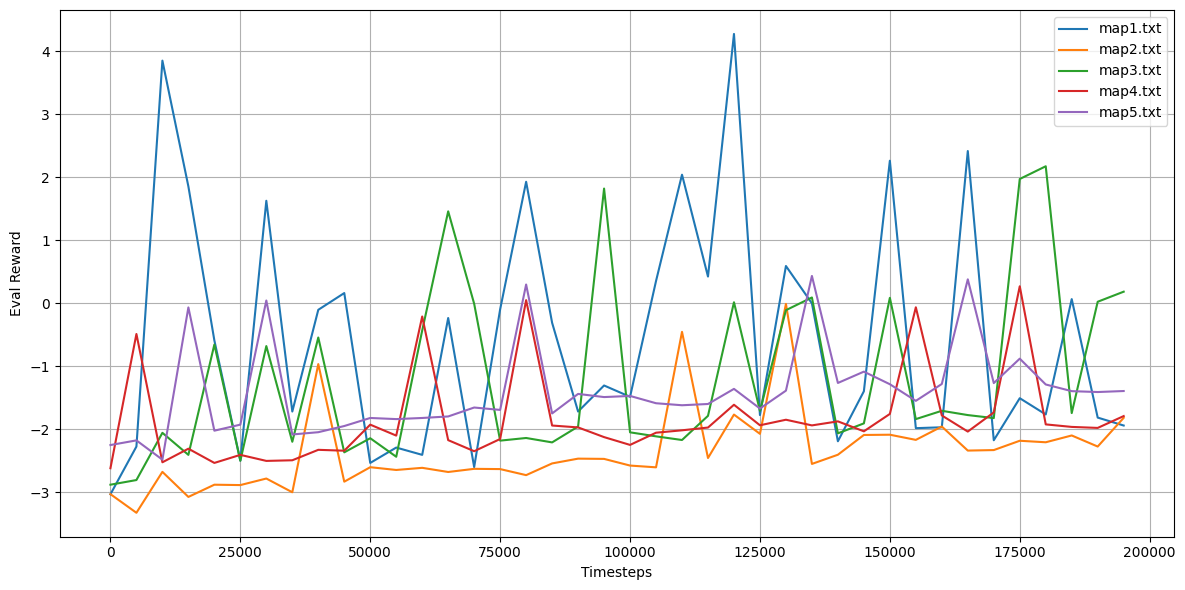

In [22]:
plt.figure(figsize=(12,6))

for map_name, rewards in reward_logger.eval_rewards.items():
    plt.plot(np.arange(len(rewards)) * 5000, rewards, label=map_name)

plt.xlabel("Timesteps")
plt.ylabel("Eval Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
results = []

for m in maps:
    test_env = DummyVecEnv([make_env(m)])

    test_env = VecNormalize.load("vecnormalize.pkl", test_env)
    test_env.training = False
    test_env.norm_reward = False

    obs = test_env.reset()
    done = False
    total_reward = 0
    step_count = 0

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = test_env.step(action)
        total_reward += rewards[0]
        step_count += 1
        done = dones[0]

    results.append({
        "Map": m,
        "Reward": total_reward,
    })


df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

     Map  Reward
map1.txt   -0.56
map2.txt   -0.52
map3.txt   -0.46
map4.txt   -0.75
map5.txt   -0.51
